# import required libraries

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

# load dataset

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X_valid, y_valid = X_train[50000:, :], y_train[50000:]
X_train, y_train = X_train[:50000, :], y_train[:50000]

print('train: ', X_train.shape, y_train.shape)
print('val: ', X_valid.shape, y_valid.shape)
print('test: ', X_test.shape, y_test.shape)

train:  (50000, 784) (50000,)
val:  (10000, 784) (10000,)
test:  (10000, 784) (10000,)


### Normalize

In [5]:
mean_vals = np.mean(X_train, axis = 0)
std_val = np.std(X_train)

X_train_norm = (X_train - mean_vals) / std_val
X_valid_norm = (X_valid - mean_vals) / std_val
X_test_norm = (X_test - mean_vals) / std_val

### reshape for CNN

In [6]:
X_train = X_train_norm.reshape(-1, 28, 28, 1)
X_valid = X_valid_norm.reshape(-1, 28, 28, 1)
X_test = X_test_norm.reshape(-1, 28, 28, 1)

### label one-hot encoding

In [7]:
train_label = to_categorical(y_train)
val_label = to_categorical(y_valid)
test_label = to_categorical(y_test)

In [8]:
print('train: ', X_train.shape, train_label.shape)
print('val: ', X_valid.shape, val_label.shape)
print('test: ', X_test.shape, test_label.shape)

train:  (50000, 28, 28, 1) (50000, 10)
val:  (10000, 28, 28, 1) (10000, 10)
test:  (10000, 28, 28, 1) (10000, 10)


# visualization function

In [9]:
def visualization(result):
    epochs = np.arange(1, 6)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, result.history['loss'], label='train loss')
    plt.plot(epochs, result.history['val_loss'], label='val loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, result.history['acc'], label='train acc')
    plt.plot(epochs, result.history['val_acc'], label='val acc')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

# trainer function

In [40]:
def train(model, batch_size, lr, optimizer_type, epochs=5):
    if optimizer_type == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = lr)
    elif optimizer_type == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate = lr, momentum=0.9)
        
    model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer, metrics = ['acc'])
    
    start_time = time.time()
    print('---------start training---------')
    result = model.fit(X_train, train_label,
                       batch_size = batch_size,
                       epochs = epochs,
                       validation_data = [X_valid, val_label])
    print(f"train time: {time.time()-start_time}")
    print('---------start testing---------')
    print(f"test accuracy: {model.evaluate(X_test, test_label)}")
    
    return result

# define model

In [53]:
model = Sequential()

model.add(Conv2D(filters=32, input_shape=(28, 28, 1), kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Activation('softmax'))

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_25 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 18, 18, 64)       

# train
- batch_size = 100
- lr = 0.01
- optimizer = adam

In [55]:
result = train(model, batch_size=100, lr=0.01, optimizer_type='adam', epochs=5)

---------start training---------
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 58us/step - loss: 0.4315 - acc: 0.8902 - val_loss: 0.1300 - val_acc: 0.9596
Epoch 2/5
50000/50000 [==============================] - 3s 54us/step - loss: 0.1308 - acc: 0.9611 - val_loss: 0.0821 - val_acc: 0.9748
Epoch 3/5
50000/50000 [==============================] - 3s 53us/step - loss: 0.1144 - acc: 0.9658 - val_loss: 0.0950 - val_acc: 0.9717
Epoch 4/5
50000/50000 [==============================] - 3s 53us/step - loss: 0.1319 - acc: 0.9605 - val_loss: 0.1024 - val_acc: 0.9727
Epoch 5/5
50000/50000 [==============================] - 3s 53us/step - loss: 0.1054 - acc: 0.9686 - val_loss: 0.0924 - val_acc: 0.9752
train time: 13.88696575164795
---------start testing---------
10000/10000 [==============================] - 1s 66us/step
test accuracy: [0.08330948877260089, 0.9754999876022339]


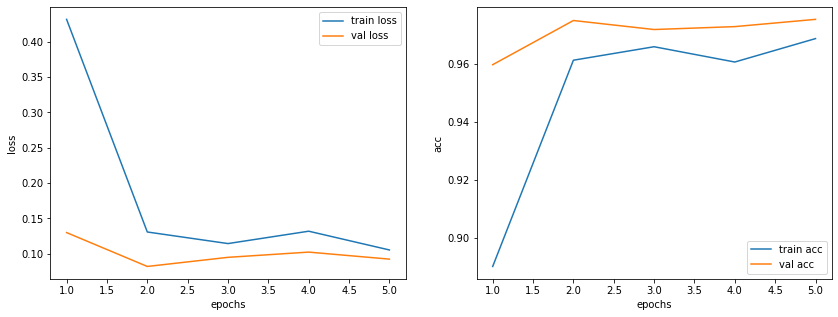

In [56]:
visualization(result)

# train
- batch_size = 100
- lr = 0.001
- optimizer = adam

In [47]:
result = train(model, batch_size=100, lr=0.001, optimizer_type='adam', epochs=5)

---------start training---------
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 58us/step - loss: 0.1639 - acc: 0.9487 - val_loss: 0.0503 - val_acc: 0.9844
Epoch 2/5
50000/50000 [==============================] - 3s 53us/step - loss: 0.0536 - acc: 0.9835 - val_loss: 0.0347 - val_acc: 0.9896
Epoch 3/5
50000/50000 [==============================] - 3s 53us/step - loss: 0.0408 - acc: 0.9870 - val_loss: 0.0390 - val_acc: 0.9884
Epoch 4/5
50000/50000 [==============================] - 3s 54us/step - loss: 0.0314 - acc: 0.9903 - val_loss: 0.0287 - val_acc: 0.9919
Epoch 5/5
50000/50000 [==============================] - 3s 53us/step - loss: 0.0282 - acc: 0.9910 - val_loss: 0.0342 - val_acc: 0.9915
train time: 13.85966157913208
---------start testing---------
10000/10000 [==============================] - 1s 65us/step
test accuracy: [0.020420690113383898, 0.9930999875068665]


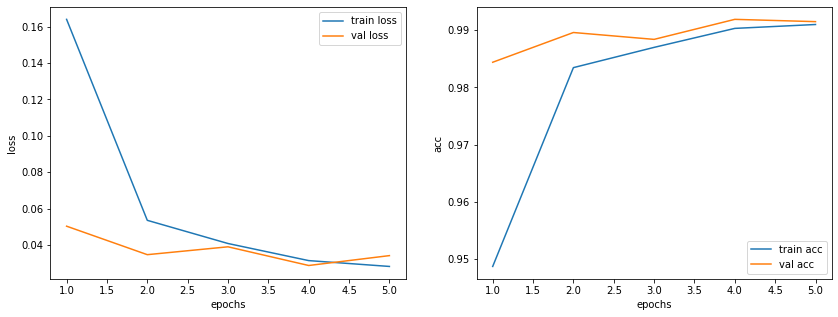

In [48]:
visualization(result)

# train
- batch_size = 100
- lr = 0.001
- optimizer = sgd

In [43]:
result = train(model, batch_size=100, lr=0.001, optimizer_type='sgd', epochs=5)

---------start training---------
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 56us/step - loss: 0.5668 - acc: 0.8208 - val_loss: 0.1131 - val_acc: 0.9683
Epoch 2/5
50000/50000 [==============================] - 3s 53us/step - loss: 0.1203 - acc: 0.9623 - val_loss: 0.0753 - val_acc: 0.9774
Epoch 3/5
50000/50000 [==============================] - 3s 52us/step - loss: 0.0858 - acc: 0.9730 - val_loss: 0.0659 - val_acc: 0.9803
Epoch 4/5
50000/50000 [==============================] - 3s 52us/step - loss: 0.0709 - acc: 0.9783 - val_loss: 0.0530 - val_acc: 0.9841
Epoch 5/5
50000/50000 [==============================] - 3s 52us/step - loss: 0.0584 - acc: 0.9817 - val_loss: 0.0497 - val_acc: 0.9851
train time: 13.542974710464478
---------start testing---------
10000/10000 [==============================] - 1s 63us/step
test accuracy: [0.04361547224451788, 0.9848999977111816]


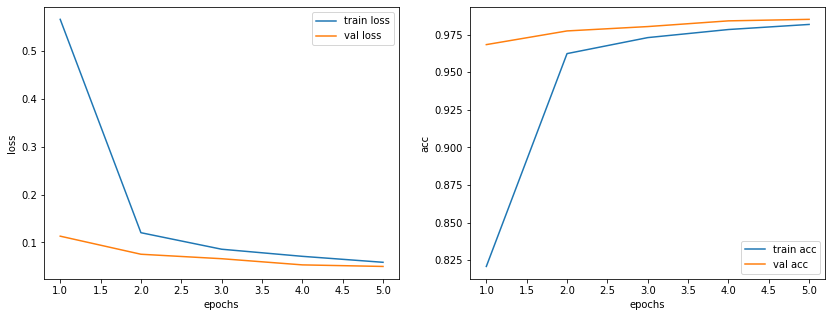

In [44]:
visualization(result)

# check prediction by visualization

In [38]:
print('prediction: ', np.argmax(model.predict(X_test[100:110]), axis = 1))

prediction:  [6 0 5 4 9 9 2 1 9 4]


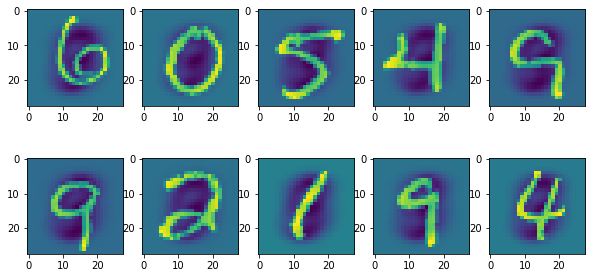

In [39]:
fig = plt.figure(figsize = (10, 5))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(X_test[i+100].reshape(28, 28))